### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 16 февраля 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

Будем рассматривать ансамбль $a(x_i) = \displaystyle \sum_{k=1}{n} f_k(x_i)$, где n - число алгоритмов.
Также, рассмотрим $a_k(x_i) = \displaystyle \sum_{p=1}{k} f_p(x_i)$

### 1.
$\dfrac{\delta L(a_k(x_i), y_i)}{\delta f_k(x_i)} = \dfrac{(y_i - a_k(x_i)) ^ 2}{\delta f_k(x_i)} = 2 \cdot (y_i - a_k(x_i)) = 2 \cdot (y_i - a_{k-1}(x_i) - f_k(x_i))$

Для каждого объекта $x_i$ будем предсказывать антиградиент функции потерь на этом объекте:

$f_k = lr \cdot (y_i - a_{k-1}(x_i))$

### 2.
$\dfrac{\delta L(a_k(x_i), y_i)}{\delta f_k(x_i)} = \dfrac{exp( -a_k(x_i) y_i)}{\delta f_k(x_i)}$

Введём обозначения: $w_i = exp(-y_i a_{k-1}(x_i)), \quad err = \dfrac{\sum_{y_i \ne f_k(x_i)}^{} w_i}{\sum_{i=1}^{N} w_i}$

На лекции было доказано, что, при такой функции потерь, нужно строить ансамбль $a_k(x_i) = a_{k-1}(x_i) + c f_k(x_i)$

$f_k(x_i) = lr \cdot (y_i \cdot exp(-a_{k-1}(x_i) y_i))$

### 3.
$\dfrac{\delta L(a(x_i), y_i)}{\delta a(x_i)} = \dfrac{\log (1 + exp( -a(x_i) y_i))}{\delta a(x_i)} = \dfrac{-y_i}{1+e^{y_i a(x_i)}}$

Для каждого объекта $x_i$ будем предсказывать антиградиент функции потерь на этом объекте:

$f_k = lr \cdot \dfrac{y_i}{1+e^{y_i a_{k-1}(x_i)}}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from numba import njit
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
from tqdm.notebook import tqdm

In [2]:
class MyGradientBoostingClassifier:

    def __init__(self, loss:str='mse', learning_rate:float=0.001, n_estimators:int=100, colsample:float=1.0, subsample:float=1.0,
                 base_model=None, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.lr = learning_rate
        self.n_estimators = n_estimators
        self.subsample = subsample
        self.colsample = colsample
        self.base_args = args
        self.base_kwargs = kwargs
        self.model = None
        self.model_features = None
        self.base_model = base_model
        self.init_bias = 0
        self.init_model = None
    
    def fit(self, X, y, base_model=None, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        if(base_model is None): base_model = self.base_model
        
        self.model = []
        self.model_features = []
        
        if(init_model is not None):
            self.init_model = init_model
            self.init_model.fit(X,y)
        if(self.loss=='mse'):
            self.init_bias = y.mean() if self.init_model is None else 0
        elif(self.loss=='exponential' or self.loss=='log-loss'):
            self.init_bias = 0
        else:
            raise NotImplementedError
        last_pred = np.full((X.shape[0],), self.init_bias, dtype=float) \
                  + (self.init_model.predict(X) if self.init_model is not None else 0)
        
        
        for i in range(self.n_estimators):
            m = base_model(*self.base_args, **self.base_kwargs)
            ids = (np.random.choice(np.arange(X.shape[0]), int(self.subsample * X.shape[0]), replace=False),
                   np.random.choice(np.arange(X.shape[1]), int(self.colsample * X.shape[1]), replace=False))
            
            if(self.loss=='mse'):
                m.fit(X[ids[0]][:,ids[1]], (y-last_pred)[ids[0]])
                last_pred += self.lr * m.predict(X[:, ids[1]])
                
            elif(self.loss=='exponential'):
                m.fit(X[ids[0]][:,ids[1]], (y*np.exp(np.array(-y*last_pred)))[ids[0]])
                preds = np.sign(m.predict(X[:, ids[1]]))
                err = np.sum(np.where(y!=preds, np.exp(np.array(-y*last_pred)), 0))\
                    / np.sum(np.exp(np.array(-y*last_pred)))
                if(err==0): break
                c = 1/2*np.log((1-err)/err)
                last_pred += self.lr * c * preds
                
            elif(self.loss=='log-loss'):
                a_prev = np.sign(last_pred)
                m.fit(X[ids[0]][:,ids[1]], (y/(1+np.exp(y*a_prev)))[ids[0]])
                last_pred += self.lr * m.predict(X[:, ids[1]])
            else:
                raise NotImplementedError
            self.model.append(m)
            self.model_features.append(ids[1])
        
    def predict(self, X):
        ids = self.model_features[0]
        y = np.full((X.shape[0],), self.init_bias) \
          + (self.init_model.predict(X) if self.init_model is not None else 0) \
          + self.model[0].predict(X[:,ids])
        # self.scores = [accuracy_score(y.round().astype(int), y_true)]
        for i in range(1, len(self.model)):
            ids = self.model_features[i]
            y += self.lr * self.model[i].predict(X[:,ids])
            # self.scores.append(accuracy_score(y.round().astype(int), y_true))
        if(self.loss=='mse'): return y.round().astype(int)
        elif(self.loss=='exponential'): return np.sign(y)
        elif(self.loss=='log-loss'): return np.sign(y)
        else: raise NotImplementedError



In [3]:
my_clf = MyGradientBoostingClassifier(n_estimators=100, loss='mse', learning_rate=0.001, max_depth=3)
clf = GradientBoostingClassifier(criterion='squared_error')

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
0.8888888888888888


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
from matplotlib import pyplot as plt
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)*2-1
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [9]:
%%time
scores = {}
params = []
for loss in ['mse', 'exponential', 'log-loss']:
    for learning_rate in [1, 0.1, 0.01]:
        for n_estimators in [10, 30, 50, 100, 200]:
            for colsample in [0.3, 0.7, 1.0]:
                for subsample in [0.5, 0.9, 1.0]:
                    for max_depth in [3, 7, 13]:
                        params.append((loss, learning_rate, n_estimators, colsample, subsample, max_depth))
                        # base_model=DecisionTreeRegressor
                        # my_clf = MyGradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, colsample=colsample,
                        #                                       subsample=subsample, base_model=base_model, max_depth=max_depth)
                        # my_clf.fit(X_train, y_train)
                        # scores[(loss, learning_rate, n_estimators, colsample, subsample, max_depth)] = accuracy_score(my_clf.predict(X_test), y_test)
                        # print(len(scores), end=' ')

# for loss, learning_rate, n_estimators, colsample, subsample, max_depth in tqdm(params):
#     base_model=DecisionTreeRegressor
#     my_clf = MyGradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, colsample=colsample,
#                                             subsample=subsample, base_model=base_model, max_depth=max_depth)
#     my_clf.fit(X_train, y_train)
#     scores[(loss, learning_rate, n_estimators, colsample, subsample, max_depth)] = accuracy_score(my_clf.predict(X_test), y_test)
                        
def train_with_params(data):
    loss, learning_rate, n_estimators, colsample, subsample, max_depth = data
    base_model=DecisionTreeRegressor
    my_clf = MyGradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators,
                                            colsample=colsample, subsample=subsample, base_model=base_model, max_depth=max_depth)
    my_clf.fit(X_train, y_train)
    return (accuracy_score(my_clf.predict(X_test), y_test), loss, learning_rate, n_estimators, colsample, subsample, max_depth)

with ThreadPool(4) as p:
    tmp = []
    for _ in tqdm(p.imap_unordered(train_with_params, params), total=len(params)):
        tmp.append(_)
        
for v in tmp:
    scores[(v[1], v[2], v[3], v[4], v[5], v[6])] = v[0]
# scores
# for n in xs:
#     my_clf = MyGradientBoostingClassifier(n_estimators=n)#max_depth=3)
#     my_clf.fit(X_train, y_train, DecisionTreeRegressor)
#     ys.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
# plt.plot(xs, ys)

  0%|          | 0/1215 [00:00<?, ?it/s]

CPU times: total: 1h 27min 1s
Wall time: 31min 22s


In [10]:
best_params = max(scores, key=lambda x:scores[x])
print(scores[best_params], best_params)

0.8982558139534884 ('log-loss', 0.1, 50, 0.7, 0.9, 13)


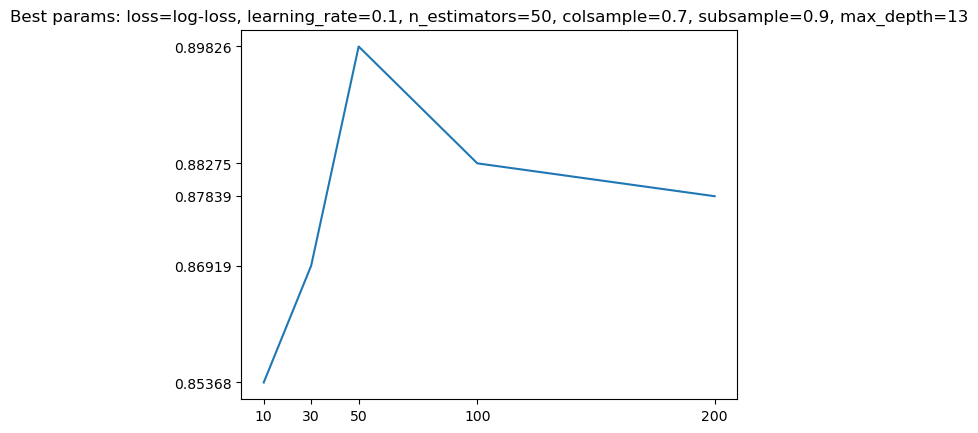

In [11]:
pts = []
for param in params:
    if(sum([param[i]==best_params[i] for i in [0,1,3,4,5]])==5):
        pts.append((param[2], scores[param]))
pts.sort()
plt.plot([p[0] for p in pts], [p[1] for p in pts])
plt.title("Best params: loss={0}, learning_rate={1}, n_estimators={2}, colsample={3}, subsample={4}, max_depth={5}".format(*best_params))
plt.xticks([p[0] for p in pts])
plt.yticks([p[1] for p in pts]);

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [12]:
%%time
loss, learning_rate, n_estimators, colsample, subsample, max_depth = best_params
my_clf = MyGradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=20,
                                        colsample=colsample, subsample=subsample, base_model=RandomForestRegressor, max_depth=max_depth)
my_clf.fit(X_train, y_train)
print(accuracy_score(my_clf.predict(X_test), y_test))

0.8502906976744186
CPU times: total: 2min 56s
Wall time: 3min 8s


Для подхода 1 - качество немного упало, а сам алгоритм обучался значительно дольше. Ухудшение качества может объясняться тем, что каждый базовый алгоритм стал значительно сильнее, и bias предсказаний уменьшился за счёт увеличения variance. При суммировании предсказаний этих базовых алгоритмов, итоговый variance также возрос, что привело к ухудшению качества. Другими словами, каждый базовый алгоритм получился гораздо более переобученным, чем в решающих деревьях, и каждому последующему алгоритму становится всё сложнее исправлять ошибки предыдущих.

In [13]:
%%time
N = 10
predict = []
for i in range(N):
    tr_ind = np.random.choice(np.arange(X_train.shape[0]), size=X_train.shape[0], replace=True)
    my_clf = MyGradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators,
                                        colsample=colsample, subsample=subsample, base_model=DecisionTreeRegressor, max_depth=max_depth)
    my_clf.fit(X_train[tr_ind], y_train[tr_ind])
    predict.append(my_clf.predict(X_test))
predict = np.sign(np.array(predict).mean(axis=0))
print(accuracy_score(predict, y_test))

0.8556201550387597
CPU times: total: 38.6 s
Wall time: 38.9 s


Для 2 подхода также наблюдается небольшое падение качества, и значительно большее время обучения, чем для одного бустинга. Ухудшение качества может объясняться тем, что каждый бустинг обучался не на полной выборке, и, соответственно, его bias на тесте был выше, чем у одного бустинга, обучавшегося на всей тренировочной выборке. При усреднении предсказаний N бустингов, их bias усреднился, и остался выше, чем у одного бустинга, обучавшегося на всей тренировочной выборке, что и могло привести к ухудшению качества.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [22]:
for init_model in [None, DecisionTreeRegressor(), RandomForestRegressor(), SVR()]:
    my_clf = MyGradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators,
                                        colsample=colsample, subsample=subsample, base_model=DecisionTreeRegressor, max_depth=max_depth)
    my_clf.fit(X_train, y_train, init_model=init_model)
    print(f"Model: {init_model}, accuracy={accuracy_score(my_clf.predict(X_test), y_test)}")

Model: None, accuracy=0.874515503875969
Model: DecisionTreeRegressor(), accuracy=0.8488372093023255
Model: RandomForestRegressor(), accuracy=0.8808139534883721
Model: SVR(), accuracy=0.875484496124031


При инициализации бустинга предсказаниями модели DecisionTreeRegressor с параметрами по умолчанию, качество упало, вероятно, вследствие того, что эта модельпереобучилась на тренировочной выборке, и бустинг также переобучился исправлять предсказания первоначальной переобученной модели.

При инициализации бустинга моделями RandomForestRegressor и SVR качество немного выросло. Это можно объяснить тем, что данные модели хорошо обобщили выборку, и не переобучились, что позволило улучшить качество по сравнению с инициализацией константой.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

